**Note: Change Hardware Accelerator to GPU to train faster (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)**

# Whisper - Machine Learning App for Disaster Relief

![](https://raw.githubusercontent.com/NolanChai/model_repo/main/Disaster_relief_image.png)

In [ ]:
#@title Run this to setup the environment and load the data
#!pip install -q seaborn pandas scikit-learn matplotlib requests
#!pip install torch==1.10.0 torchtext==0.11.0
import re
import seaborn as sns
import pandas as pd
import numpy as np
#from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split

!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Disaster%20Relief/disaster_data.csv'
dataset_path = './disaster_data.csv'

#Temp getting glove vectors from another resource - Stanford server shutdown till July 4 2023
!wget http://nlp.uoregon.edu/download/embeddings/glove.6B.300d.txt

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import requests, io, zipfile

disaster_data.csv.1 100%[===================>] 222.42K  --.-KB/s    in 0.007s  
--2025-02-12 14:43:07--  http://nlp.uoregon.edu/download/embeddings/glove.6B.300d.txt
Resolving nlp.uoregon.edu (nlp.uoregon.edu)... 128.223.8.161, 2607:8400:205e:8:ae1f:6bff:fe93:6364
Connecting to nlp.uoregon.edu (nlp.uoregon.edu)|128.223.8.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1037962819 (990M) [text/plain]
Saving to: ‘glove.6B.300d.txt.1’

glove.6B.300d.txt.1 100%[===================>] 989.88M  19.4MB/s    in 34s     

2025-02-12 14:43:41 (28.9 MB/s) - ‘glove.6B.300d.txt.1’ saved [1037962819/1037962819]



# Part 1: Disaster Tweet Classification

Let's construct a machine learning model to classify disaster types from tweets!





##Load the data

In [ ]:
disaster_tweets = pd.read_csv('disaster_data.csv', encoding="ISO-8859-1", na_filter=False)
disaster_tweets.head()

,tweet_id,text,category,need_or_resource
0,ca9e24c8-396d-4502-8b45-18895df5333e_0,"Donations of batteries, flashlights, and clean...",Energy,need
1,twitter_resource_tweets_1692,I want hurricane Sandy to cone so I can be stu...,None,None
2,625b46e2-0b81-41ea-826e-4535fe9b39b8,"Hi, I can help prepare food, serve food, offer...",Food,resource
3,twitter_resource_tweets_1699,I cant believe Sandy.....,None,None
4,c3bfea72-d377-445c-b4b8-e8ebca0e7fbb,I have children and adult clothes including ja...,Water,resource


###Extract the tweets and the respective labels


In [ ]:
#Read the tweet data and convert it to lowercase
tweets = disaster_tweets['text'].str.lower()
tweets = tweets.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ',x))
#Extract the labels from the csv
tweet_labels = disaster_tweets['category']

##Processing Our Data

###Train-Test Split


Now that our data is ready, we can perform our usual `train_test_split`. Pass in our data and our output, `y`. You can use a test size of 0.2.

In [ ]:
#Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(tweets, tweet_labels, test_size=0.2, random_state=1,stratify = tweet_labels)

###Load Glove Embeddings

In [ ]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(file_path, vec_size=300):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')

            # Ensure all vectors have the correct size
            if len(vector) == vec_size:
                embeddings[word] = vector
    return embeddings

# Load the GloVe embeddings with 300 dimensions
glove = load_glove_embeddings("glove.6B.300d.txt")  # Ensure you have the correct path

# Returns word vector for word if it exists, else return a zero vector of size 300
def get_word_vector(word, vec_size=300):
    # Convert the word to lowercase and check if it's in the embeddings dictionary
    word = word.lower()
    return glove.get(word, np.zeros(vec_size))  # Return a zero vector if word is not found

# Testing the get_word_vector function
good_vector = get_word_vector('good')
print('Shape of "good" vector:', good_vector.shape)
print(good_vector)

Shape of "good" vector: (300,)
[-1.3602e-01 -1.1594e-01 -1.7078e-02 -2.9256e-01  1.6149e-02  8.6472e-02
  1.5759e-03  3.4395e-01  2.1661e-01 -2.1366e+00  3.5278e-01 -2.3909e-01
 -2.2174e-01  3.6413e-01 -4.5021e-01  1.2104e-01 -1.5596e-01 -3.8906e-02
 -2.9419e-03  1.6009e-02 -1.1620e-01  3.8680e-01  3.5109e-01  9.7426e-02
 -1.2425e-02 -1.7864e-01 -2.3259e-01 -2.6960e-01  4.1083e-02 -7.6194e-02
 -2.3362e-01  2.0919e-01 -2.7264e-01  5.4967e-02 -1.8055e+00  5.6348e-01
 -1.2778e-01  2.3147e-01 -5.8820e-03 -2.6630e-01  4.1187e-01 -3.7162e-01
 -2.0600e-01 -1.9619e-01 -4.3945e-03  1.2513e-01  4.6638e-01  4.5159e-01
 -1.5000e-01  5.9589e-03  5.9070e-02 -4.1440e-01  6.1035e-02 -2.1117e-01
 -4.0988e-01  5.6393e-01  2.3021e-01  2.7240e-01  4.9364e-02  1.4239e-01
  4.1841e-01 -1.3983e-01  3.4826e-01 -1.0745e-01 -2.5002e-01 -3.2554e-01
  3.3343e-01 -3.5617e-01  2.0442e-01  1.4439e-01 -1.2686e-01 -7.7273e-02
 -1.9667e-01  1.0759e-01 -1.1860e-01 -2.5083e-01  1.4205e-02  2.7251e-01
 -2.3707e-01 -2.3545

###Convert list of descriptions into an array of GloVe vectors

In [ ]:
def glove_transform_data_descriptions(data):
    X = np.zeros((len(data), VEC_SIZE))


    for i, tweet in enumerate(data):
        found_words = 0.0
        tweet = tweet.strip()
        for word in tweet.split():

            vec = get_word_vector(word)
            if vec is not None:
                ### YOUR CODE HERE ###
                # Increment found_words and add vec to X[i].
                found_words += 1
                X[i] += vec
                ### END CODE HERE ###
        # We divide the sum by the number of words added, so we have the
        # average word vector.
        if found_words > 0:
            X[i] /= found_words

    return X

glove_train_X = glove_transform_data_descriptions(X_train)
glove_train_y = [label for label in y_train]
print ("Train_shape",glove_train_X.shape)
glove_test_X = glove_transform_data_descriptions(X_test)
glove_test_y = [label for label in y_test]
print ("Test shape",glove_test_X.shape)

Train_shape (1086, 300)
Test shape (272, 300)


##Training Our Model

The model we are going to try to use is a Logistic Regression model which will be trained on the GloVe-transformed dataset.


In [ ]:
model = LogisticRegression()
model.fit(glove_train_X, glove_train_y)

glove_train_y_pred = model.predict(glove_train_X)
print('Train accuracy', accuracy_score(glove_train_y, glove_train_y_pred))

glove_test_y_pred = model.predict(glove_test_X)
print('Val accuracy', accuracy_score(glove_test_y, glove_test_y_pred))

print('Confusion matrix:')
print(confusion_matrix(glove_test_y, glove_test_y_pred))

prf = precision_recall_fscore_support(glove_test_y, glove_test_y_pred)

print('Precision:', prf[0][1])
print('Recall:', prf[1][1])
print('F-Score:', prf[2][1])

Train accuracy 0.9033149171270718
Val accuracy 0.875
Confusion matrix:
[[ 17   6   0  10   0]
 [  0 131   0   1   0]
 [  0   3   7   0   0]
 [  6   2   1  63   0]
 [  0   4   0   1  20]]
Precision: 0.8972602739726028
Recall: 0.9924242424242424
F-Score: 0.9424460431654677


###Evaluate the Model

              precision    recall  f1-score   support

      Energy       0.74      0.52      0.61        33
        Food       0.90      0.99      0.94       132
     Medical       0.88      0.70      0.78        10
        None       0.84      0.88      0.86        72
       Water       1.00      0.80      0.89        25

    accuracy                           0.88       272
   macro avg       0.87      0.78      0.81       272
weighted avg       0.87      0.88      0.87       272

Plotting the Confusion Matrix


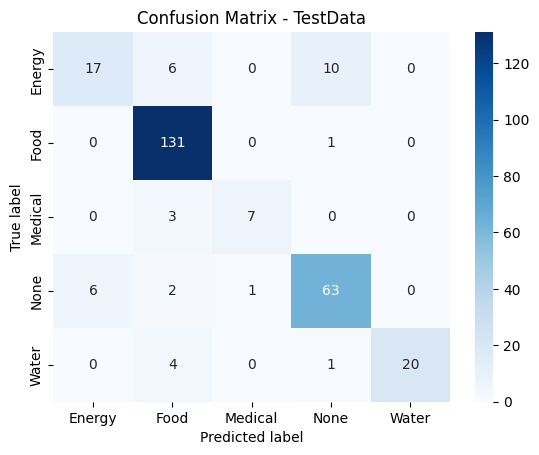

In [ ]:
#Prints the classification report
print(classification_report(y_test,glove_test_y_pred, target_names=['Energy', 'Food', 'Medical', 'None', 'Water']))

'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ['Energy', 'Food', 'Medical', 'None', 'Water']
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()
plot_confusion_matrix(y_test,glove_test_y_pred)

###Saving our Whisper Model

Now let's save and download our `whisper_model`

In [ ]:
import joblib
from google.colab import files

joblib.dump(model, "whisper_model.joblib")
files.download("whisper_model.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Visualize the Embeddings in 3D

In [ ]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import plotly.express as px

import re
import matplotlib.pyplot as plt

def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]

sentences = [line for text in tweets for line in clean(text)]

#min-count variable helps us eliminate the words which rarely occur!
model = Word2Vec(sentences, workers=4, vector_size=100, min_count=30, window=10, sample=1e-3)


def tsne_plot_3d(model):
    "Creates a TSNE model and plots it in 3D"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv.get_vector(word, norm=True))
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])

    fig = px.scatter_3d(x=x, y=y, z=z, text=labels)
    fig.update_traces(textposition='top center')
    fig.update_layout(title_text='GloVe Word Embeddings in 3D')
    fig.show()
tsne_plot_3d(model)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


# Part 2: Setting Up Our Disaster Relief App

---



### Setting up Ngrok auth token

In [ ]:
!pip -q install pyngrok > /dev/null
!pip -q install streamlit > /dev/null
!pip -q install patool > /dev/null
!pip -q install keras==3.5.0 > /dev/null
!ngrok authtoken 2stAYuQD6aIsjzhXhLPLZR7KiMI_5j5bT8XEFmzBwWtLFV72L

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### Connecting Our App and Model


Let's connect our app to our model, so that the user can upload an image of a blood slide, the model will analyze the image, and finally the app will display the diagnosis result with some text.

We'll start off by writing our image processing code here in Colab. Although we won't execute it here, it'll be easier to visualize the steps.

In [ ]:
import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import patoolib
import streamlit as st

from joblib import dump
from tqdm import tqdm
from pyngrok import ngrok
# Helpful function for launching our Streamlit app
def launch_website():
  print ("Click this link to try your web app:")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  tunnel = ngrok.connect()
  print(tunnel.public_url)
  !streamlit run --server.port 80 app.py > /dev/null
launch_website()

Click this link to try your web app:
https://f02b-34-69-104-17.ngrok-free.app


###Designing the interface

In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np

VEC_SIZE = 300

# Load GloVe embeddings from a local file
def load_glove_embeddings(file_path, vec_size=300):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')

            # Ensure all vectors have the correct size
            if len(vector) == vec_size:
                embeddings[word] = vector
    return embeddings

# Load the GloVe embeddings (ensure you have the correct path)
glove = load_glove_embeddings("glove.6B.300d.txt")

# Load the model
model = joblib.load('whisper_model.joblib')

st.set_page_config(page_title="Whisper: Disaster Relief NLP Analysis", layout="wide")

# Header Section
st.title("Whisper: Disaster Relief NLP Analysis")
st.markdown("""
    This tool analyzes user-provided tweets to predict whether they relate to disaster relief efforts.
    Simply enter your tweet, and Whisper will provide a prediction based on a pre-trained model.
""")

# Function to transform tweet data to vector using GloVe embeddings
def glove_transform_data_descriptions(data):
    X = np.zeros((len(data), VEC_SIZE))

    for i, tweet in enumerate(data):
        found_words = 0.0
        tweet = tweet.strip()
        for word in tweet.split():

            vec = get_word_vector(word)
            if vec is not None:
                # Increment found_words and add vec to X[i].
                found_words += 1
                X[i] += vec
        # We divide the sum by the number of words added, so we have the
        # average word vector.
        if found_words > 0:
            X[i] /= found_words

    return X

# Returns word vector for word if it exists, else return a zero vector of size 300
def get_word_vector(word, vec_size=300):
    word = word.lower()
    return glove.get(word, np.zeros(vec_size))  # Return a zero vector if word is not found

# User Input Section
st.header("Tweet Input")
st.markdown("""
    Enter up to three tweets below. Each will be analyzed for its relevance to disaster relief.
    After entering the tweet, the tool will display its prediction.
""")

user_inputs = []
for i in range(3):
    prompt = f"Tweet {i + 1}:"
    user_input = st.text_input(prompt)
    user_inputs.append(user_input)

predictions = []

# Display predictions if tweets are entered
if any(user_inputs):
    st.subheader("Prediction Results")
    for user_input in user_inputs:
        if user_input:
            glove_input = glove_transform_data_descriptions([user_input])
            prediction = model.predict(glove_input)
            predictions.append(f"Prediction for Tweet: {prediction[0]}")
            st.write(predictions[-1])
else:
    st.warning("Please enter at least one tweet to get a prediction.")

# Optional: Add footer with contact info or further instructions
st.markdown("""
    ---
    For more information about how Whisper works or if you would like to integrate this tool into your platform,
    please contact us at [oluwatoyosi.abolaji25@gmail.com](mailto:oluwatoyosi.abolaji25@gmail.com).
""")

Overwriting app.py
